# DS7331 Project 3
#### Group 2: Hollie Gardner, Cleveland Johnson, Shelby Provost
[Dataset Source](https://archive-beta.ics.uci.edu/ml/datasets/census+income)<br/>
[Github Repo](https://github.com/ShelbyP27/DS7331-Project)

In [1]:
#import libraries
import pandas as pd
import numpy as np
import os
import sklearn as sk
#import lazypredict

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

#pca and gridsearch
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#prediction models
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.neighbors import KNeighborsClassifier

#exceptional work (working on this)
import math 
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import register_matplotlib_converters



In [2]:
# code from michael hahsler's github -- https://mhahsler.github.io/arules/docs/python/arules_python.html
from rpy2.robjects import pandas2ri
pandas2ri.activate()

import rpy2.robjects as ro
from rpy2.robjects.packages import importr

arules = importr("arules")

# some helper functions
def arules_as_matrix(x, what = "items"):
    return ro.r('function(x) as(' + what + '(x), "matrix")')(x)

def arules_as_dict(x, what = "items"):
    l = ro.r('function(x) as(' + what + '(x), "list")')(x)
    l.names = [*range(0, len(l))]
    return dict(zip(l.names, map(list,list(l))))

def arules_quality(x):
    return x.slots["quality"]

C:\Users\shelb\anaconda3\envs\DS7331\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
#association rules
import time
%matplotlib inline
from rpy2.robjects.packages import importr
from rpy2 import robjects as robj

%load_ext rmagic
%load_ext rpy2.ipython 
# this enables the %R extension to iPython (does not work outside of the iPython shell)

# these packages will need to be installed
# open R and run 
#     install.package(arules)
#     install.package(arulesViz)
#lib='C:/Users/johnc45/R/R-Library'
#arules = importr('arules', lib_loc=lib) # same as importing in R with the "library" command
#arules_viz = importr('arulesViz', lib_loc=lib) # visualize the different rules

C:\Users\shelb\anaconda3\envs\DS7331\lib\site-packages\IPython\extensions\rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "


## Data Preparation

### Loading and Prepping Data 


In [25]:
# Importing the census dataset using pandas
# Reading the CSV file after converting file to csv and removing superfluous spaces via Excel.
df = pd.read_csv('https://raw.githubusercontent.com/ShelbyP27/DS7331-Project/main/adult-data.csv')

# Getting a first look at the dataset
#df.head()

In [26]:
#Cleaning up data set
df = df.replace(to_replace='?',value=np.nan) # replace '?' with NaN (not a number)
df.dropna(inplace=True) # Removing na values
df.duplicated(subset=None, keep='first') #Remove duplicates
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int) #One-hot respone
df3 = df

In [27]:

# One-hot encoding the Categorical variables
if 'sex' in df:
    df['IsMale'] = df.sex == 'Male'
    df.IsMale = df.IsMale.astype(np.int64)
    del df['sex']
    
if 'marital-status' in df:
    tmp_df = pd.get_dummies(df['marital-status'], prefix = 'Marital')
    df = pd.concat((df, tmp_df), axis =1)
    del df['marital-status']
    
if'relationship' in df:
    tmp_df = pd.get_dummies(df['relationship'], prefix = 'Rel')
    df = pd.concat((df, tmp_df), axis =1)
    del df['relationship']

if 'race' in df:
    tmp_df = pd.get_dummies(df['race'], prefix = 'Race')
    df = pd.concat((df, tmp_df), axis =1)
    del df['race']

if 'workclass' in df:
    tmp_df = pd.get_dummies(df['workclass'], prefix = 'Work')
    df = pd.concat((df, tmp_df), axis =1)
    del df['workclass']

if 'occupation' in df:
    tmp_df = pd.get_dummies(df['occupation'], prefix = 'Occupation')
    df = pd.concat((df, tmp_df), axis =1)
    del df['occupation']

if 'education' in df:
    tmp_df = pd.get_dummies(df['education'], prefix = 'Education')
    df = pd.concat((df, tmp_df), axis =1)
    del df['education']

    
#Replace Native Country with Immigrant atribute
if 'native-country' in df:
    df['immigrant'] = np.where(df['native-country']!= 'United-States', 1, 0)
    del df['native-country']

df2 = df
    

In [28]:
# Separate features from the response
if 'income' in df:
    y = df['income'].values
    del df['income']
    X = df.values

# Train / Test split with scaled_X
scaled_X = StandardScaler().fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(scaled_X, y, test_size = .2, random_state=1)


In [29]:
Xnew = df[['age','hours-per-week', 'capital-loss','education-num','Marital_Never-married','Marital_Married-civ-spouse','Work_Private', 'Rel_Husband','capital-gain','Rel_Not-in-family']].values

newscaled_X = StandardScaler().fit_transform(Xnew)
x_train, x_test, y_train, y_test = train_test_split(newscaled_X, y, test_size = .2, random_state=1)

## Business Understanding
*Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?*
<br><br>
Census data is regularly collected by the US Census Bureau in order for the government to understand the characteristics of US population. Data collected from every household in the US through census surveys typically includes details on a number of items such as number of people in the household, income, profession, race/ethnity, languages spoken, sex, age, etc. This dataset was extracted from the 1994 Census database by Barry Becker for the purpose of predicting if an individual's income is greater than $50k.
<br><br>
The outcome of this data set is to assess if an indivdual has an income greater than &dollar;50k. Since the data set was given with the income listed as greater than 50k or less than 50k, the definition of the outcome is straight foward. We would measure the outcome by assessing the predictor variables for significance in predicting an individuals income. The statistically significant variables should have a minimal error in predictability.
<br><br>
The effectiveness of a good prediction algorithm would be measured through the error rates in the algorithm's ability to classify learn from the training data and predict the individual income categories in the test set based off of the attributes provided.


## Data Understanding
*Part One: Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?*

This dataset contains 15 attributes for 32,560 instances in the training set. The test set includes an additional 16,281 instances. In addition to the code below, details were obtained from the adult.names file provided by dataset donors from the above linked UCI website.

The attribute descriptions are as follows:
* **age** (integer, range 17-90 ): This is the age of the individual. 
* **workclass** (categorical, 9 levels): Work class is the sector or category of the individual's occupation
* **fnlwgt** (integer, range 13769-1484705): The "final weight" attribute was calculated from the Current Population Survey and "refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population." (See full description of this attribute from Kohavi and Becker below)
* **education** (categorical, 16 levels): Highest level of education the individual has obtained
* **education-num** (integer, range 1-16): ___
* **marital-status** (categorical, 7 levels): The individual's marital status
* **occupation** (categorical, 15 levels): The type of work an individual performs
* **relationship** (categorical, 6 levels): ____
* **race** (categorical, 5 levels): Individual's racial group
* **sex** (categorical, 2 levels): Male or Female
* **capital-gain** (integer, range 0-99999): _____
* **capital-loss** (integer, range 0-4356): _____
* **hours-per-week** (integer, range 1-99): Number of hours per week individual works in occupation
* **native-country** (categorical, 42 levels): The individual's native country
* **income** (categorical, 2 levels): This has been converted from the raw data to be less than or equal to $50K or greater than $50K
<br>
<br>**Kohavi and Becker Description of Final Weight from adult.names file:**
<br>
<br>| The weights on the CPS files are controlled to independent estimates of the
<br>| civilian noninstitutional population of the US.  These are prepared monthly
<br>| for us by Population Division here at the Census Bureau.  We use 3 sets of
<br>| controls.
<br>|  These are:
<br>|          1.  A single cell estimate of the population 16+ for each state.
<br>|          2.  Controls for Hispanic Origin by age and sex.
<br>|          3.  Controls by Race, age and sex.
<br>|
<br>| We use all three sets of controls in our weighting program and "rake" through
<br>| them 6 times so that by the end we come back to all the controls we used.
<br>|
<br>| The term estimate refers to population totals derived from CPS by creating
<br>| "weighted tallies" of any specified socio-economic characteristics of the
<br>| population.
<br>|
<br>| People with similar demographic characteristics should have
<br>| similar weights.  There is one important caveat to remember
<br>| about this statement.  That is that since the CPS sample is
<br>| actually a collection of 51 state samples, each with its own
<br>| probability of selection, the statement only applies within
<br>| state.


According to the Kohavi and Becker, the following changes have already been made to the raw data:
* Discretized agrossincome into two ranges with threshold 50,000.
* Convert U.S. to US to avoid periods.
* Convert Unknown to "?"
* Run MLC++ GenCVFiles to generate data,test.
<br>

Therefore, we will begin by looking for the '?' values in the dataset by counting the number in each column. Then, we will replace as null using numpy. We decided to handle missing values in the following three variables which possessed missing values as below: 

* Workclass: 1836 rows
* Occupation: 1843 rows
* Native-Country: 583 rows

There is not a way to impute values for these categorical variables and leaving as unknown variables does not add value to our analysis. Therefore, these rows will be removed leaving us with 30,162 complete rows in this dataframe.

As for duplicates, Kohavi and Becker described 6 duplicate rows. After reviewing our current dataframe, there do not appear to be any instances of duplicate data.


*Part Two: Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.*

Initial visual assessment led us to identify 7 attributes that could be important in terms of identifying whether income is greater than or less than \$50k.  The 7 attributes were comprised of 3 numeric (Age, Education-Num, Hours-per-week) and 4 categorical (Marital Status, Relationship, Race and Sex). Further analysis, with the use of one-hot-coded predictor variables, provided further insight into the variables that are important in predicting whether income is greater than or less that \$50k. An initial logistic regression model proposed the following variables as important features: Age, Hours-per-week, Capital Loss, Education-Num, Marital-Never-married, Marital-married-civ-spouse, Work-private, Rel-husband, Capital Gain, and Rel-not-in-family. A simplified logistic regression model proposed these variables as important features: Age, Capital Loss, and Marital-married-civ-spouse. 

While Race and Sex had visual differences in whether income was greater than or less than /$50k, the results of the logitic regressions suggest that the weight of these variables in prediction is actually low. This could be due to disproportionate samples of each category in the data. However, the logitic regression helped narrow the list of which attributes would be important. Age, Education-Num, Hours-per-week, Marital-Status, and Relationship agree to be imporant varibles in predicting whether an individual makes more than or less than /$50k and each of them are visulaized below. 





**Age**: This age histrogram is subsetting for the reponse variable, income.  The histogram shows the right skew of the <\$50k histogram and the relative normalcy of the >\$50k historgram.  The initial logistic regression found that if the age of an individual increases by one unit, the esimated odds of having an income greater than 50k change by a factor of 0.99. In other words, the odds decrease by 1%.

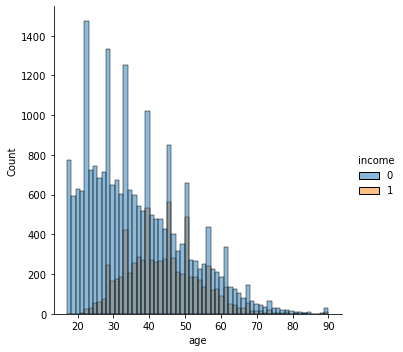

In [32]:
sns.displot(df3,x="age",hue="income")

**Education-Num**:  This histogram demonstrates a very low number of occurrences for income >\$50k prior to 9 years.  The ratios between greater than and less than \$50k begin to flip as the numbers increase from 9. 

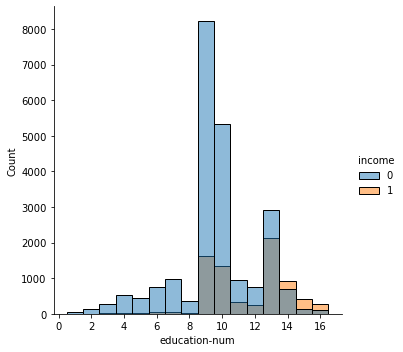

In [33]:
sns.displot(df3,x="education-num", discrete=True,hue="income")

**Hours-Per-Week**: A Kernel density estimation plot was used to make the hours-per-week attribute more easily readable.  The choice becomes obvious when compared to the histogram below.  The histogram is quite difficult to read due to the high smapling rate at the 40 hours per week.  While the Kernel Denity does not provide an accurate count, it does help showcase the greater than \$50k curve that is near zero prior to 40 hours per week adn then tapers to somewhere between 60 and 80 hours per week.  The ratio between geater than and less than \$50k increases as the curve tapers to the right.

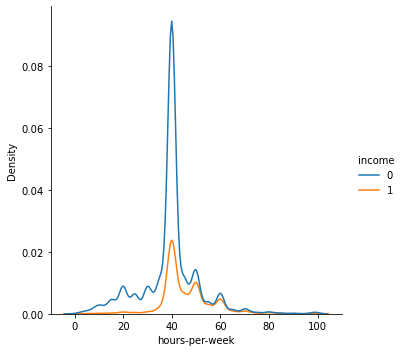

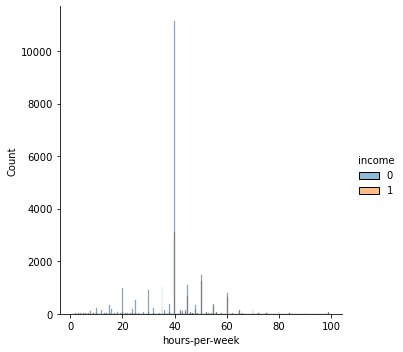

In [34]:
sns.displot(df3,x="hours-per-week",hue="income", kind='kde')
sns.displot(df3,x="hours-per-week",hue="income")

**Marital-Status**: A proportional plot was used to for martial-status. The propportional plot provides the percentage of responses that are greater than \$50k (true) as opposed to less than \$50k (false). We've added a stacked bar chart with count along side the proportional chart. The stacked bar chart is helpful, but due to the size of one category, married-civ-spouse in this case, the other counts are almost invisible. The proportion chart enables the observation of each category to understand it's impact on the response. The initial logistic regression found that if a person is a married civilian spouse, the estimated odds of having an income greater than 50k is .03% higher than someone who is not a married civilian spouse.

<AxesSubplot:xlabel='marital-status'>

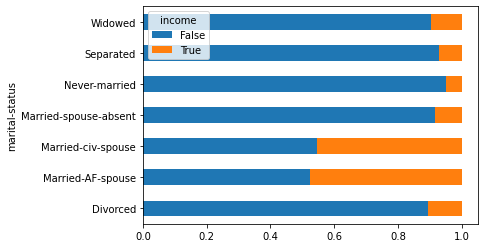

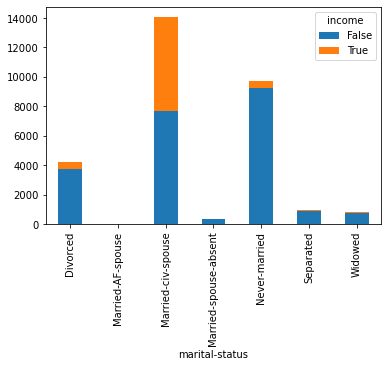

In [35]:
income_marital = pd.crosstab([ df3['marital-status'] ], df3.income.astype(bool))
marital_rate = income_marital.div(income_marital.sum(1).astype(float),axis=0)
marital_rate.plot(kind='barh', stacked=True)

income_marital.plot(kind='bar', stacked=True)

**Relationship**: Continuing to leverage the proporation plot for the categorical variables, this plot shows a clear separation between Husband/Wife and the other categories.  The Husband and Wife category have more than 40\% responses for greater than \$50k.  

<AxesSubplot:ylabel='relationship'>

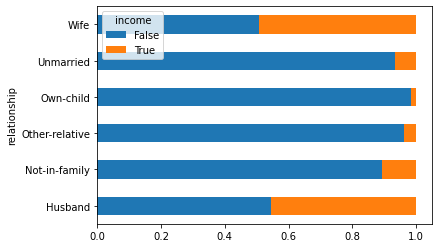

In [36]:
income_relationship = pd.crosstab([ df3['relationship'] ], df3.income.astype(bool))
relationship_rate = income_relationship.div(income_relationship.sum(1).astype(float),axis=0)
relationship_rate.plot(kind='barh', stacked=True)

## Modeling and Evaluation
*Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results.*
 

### Option A: Cluster Analysis

 - Perform cluster analysis using several clustering methods
 - How did you determine a suitable number of clusters for each method?
 - Use internal and/or external validation measures to describe and compare the clusterings and the clusters (some visual methods would be good).
 - Describe your results. What findings are the most interesting and why? 


### Option B: Association Rule Mining
 - Create frequent itemsets and association rules.
 - Use tables/visualization to discuss the found results.
 - Use several measure for evaluating how interesting different rules are.
 - Describe your results. What findings are the most compelling and why? 

In [10]:
%R -i df rules <- apriori(df,parameter = list(minlen=2, supp=0.05, conf=0.8))
%R rules.sorted <- sort(rules, by='lift')
%R plot(rules.sorted, method='grouped')

C:\Users\shelb\anaconda3\envs\DS7331\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "Marital_Divorced". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
C:\Users\shelb\anaconda3\envs\DS7331\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "Marital_Married-AF-spouse". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
C:\Users\shelb\anaconda3\envs\DS7331\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "Marital_Married-civ-spouse". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
C:\Users\shelb\anaconda3\envs\DS7331\lib\site-packages\rp

AttributeError: type object 'DataFrame' has no attribute 'from_items'

In [11]:
%R -o df_from_R df_from_R<-df

# now we have the exact same dataset as the one from R
# but it is now a pandas dataframe
print(df_from_R.info())

AttributeError: type object 'DataFrame' has no attribute 'from_items'

### Option C: Collaborative Filtering
 - Create user-item matrices or item-item matrices using collaborative filtering
 - Determine performance of the recommendations using different performance measures and explain what each measure
 - Use tables/visualization to discuss the found results. Explain each visualization in detail.
 - Describe your results. What findings are the most compelling and why? 

## Deployment
 - Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
 - How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
 - How would your deploy your model for interested parties?
 - What other data should be collected?
 - How often would the model need to be updated, etc.? 

## Exceptional Work
 - You have free reign to provide additional analyses or combine analyses 